In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime


#input file name
DATA_FILE = "fuel_levels50.csv"

#original columns names
FUEL_LEVEL = "fuel_level"
TIME = "time"
VEHICLE_ID = "vehicle_id"
ENGINE_ON = "engine_on"
PROVIDER_ID = "provider_id"

#new columns names
#columns starting with "roll" are caculted on rolling window
DATETIME = 'datetime'
DELTA_TIME = "delta_time"
DELTA_FUEL = "delta_fuel"
IS_THEFT = "suspicion_of_theft"

ROLL_TIME = "rolling_difference_time"
ROLL_FUEL = "rolling_difference_fuel"
ROLL_RATE = "rolling_difference_rate"
ROLL_ENGINE_ON = "rolling_engine_on"


#display option
pd.options.display.float_format = '{:.3f}'.format


In [65]:
#read data into a data frmae and drop index column 
df = pd.read_csv(DATA_FILE)
df.drop(df.columns[0],axis=1,inplace=True)

#show head
df.head()

,engine_on,time,fuel_level,provider_id,vehicle_id
0,1,1448738636105.800,178.836,2,26
1,1,1449367017443.487,23.550,1,21
2,1,1445733458105.648,27.928,2,40
3,1,1445192368945.336,29.950,1,22
4,1,1448686185252.171,253.891,2,12


In [66]:
#data Preparation

def smooth_fuel_level(group, win=3):
    '''
    smooth fuel level data by moving average method
    '''
    roll = group[[FUEL_LEVEL]].rolling(window=win, min_periods=1)
    group[FUEL_LEVEL] = roll.mean()
    return group

#sort by id and time, and reset index 
df.sort_values(by=[VEHICLE_ID, TIME], inplace=True)
df = df.reset_index(drop=True)

#smooth data of fuel level with moving average method
df = df.groupby([VEHICLE_ID]).apply(smooth_fuel_level)

#calculate delta time and delta fuel level
df[DELTA_TIME] = df.groupby([VEHICLE_ID])[TIME].diff()
df[DELTA_FUEL] = df.groupby([VEHICLE_ID])[FUEL_LEVEL].diff()

#add datetime column
df[DATETIME] = pd.to_datetime(df[TIME],unit='ms')

In [132]:
#help-functions definitions 

def f(x):
    return (np.sum(x) / 1000) # convert to seconds

def minutes_to_window_size(minutes,interval): #time window in minutes
    '''
    gets delta time in minutes and intrval, and find
    what size of a window (i.e., num observations) 
    captures (at least) this delta time 
    '''
    milliseconds = minutes*60*1000
    window_size = milliseconds / interval
    return int(window_size)

def calculate_fuel_level_diff_rate(df, window, min_per):
    '''
    calcultes difference rate in fuel-level.
    change rate in fuel-level is the change amount in fuel level 
    divided by change amount in time, along a specified window. 
    units: liters / seconds  
    '''
    df[ROLL_FUEL] = df[DELTA_FUEL].rolling(window, 
                                            min_periods=min_per).sum()
    df[ROLL_TIME] = df[DELTA_TIME].rolling(window, 
                                            min_periods=min_per).apply(f, raw=True)

    #calculate rate - amount of fuel / time (liters/seconds )
    df[ROLL_RATE] = df[ROLL_FUEL] / df[ROLL_TIME]
    
    return df

def is_engine_on(df, window, min_per):
    '''
    calculates whether in a corresponding time window engine is on.
    determine if engine on by the median value 
    (there are only two possible values so median should be ok)
    '''
    df[ROLL_ENGINE_ON] = df[ENGINE_ON].rolling(window, 
                                                min_periods=min_per).median()
    return df


def find_thefts_on(df, quntile):
    
    #get observations where there is a negative difference in fuel level
    df = df[df[ROLL_RATE] < 0]
    
    #find sharp decreases in fuel level
    #by getting rates values under specified quntile 
    #(i.e. large absolute values of rates) 
    df = df.loc[df[ROLL_RATE] < df[ROLL_RATE].quantile(quntile)]
    
    return df

def find_thefts_off(df):
    
    #engine_off = df[df[DELTA_TIME] > 2000]
    #print(engine_off.shape[0], engine_off[engine_off[ENGINE_ON]==0].shape[0])
    
    engine_on = df[df[ENGINE_ON] == 0][DATETIME] 
    print(engine_on.index)
    #for each index find the most recent time - before and after 
    
    ls = []
    for index in engine_on.index:
        t = engine_on.loc[index, DATETIME]
        delta_t =
        df[df[DATETIME] > t & ]
        
        
    
        

def is_theft(df, quntile):
    '''
    determines whether in a corresponding time window was a theft 
    '''
    #distinguish between two cases - engine on and engine off
    #engine_on = df[df[ROLL_ENGINE_ON]==1]
    #engine_off = df[df[ENGINE_ON]==0]
   
    #get indexes of thefts
    thefts_on = find_thefts_on(df, quntile)
    find_thefts_off(df)
    
    #add column of is theft, initialize with False
    df[IS_THEFT] = False
    
    #set True in the suspected locations
    df.loc[thefts_on.index, [IS_THEFT]] = True
   
    return df



In [68]:
#find thefts 

#define window size 
interval = df[DELTA_TIME].median()
window = minutes_to_window_size(10, interval)
min_per = minutes_to_window_size(1, interval)

#calculate fuel-level change rate 
df = df.groupby([VEHICLE_ID]).apply(calculate_fuel_level_diff_rate, window, min_per)

#whether engine on during time window 
df = df.groupby([VEHICLE_ID]).apply(is_engine_on, window, min_per)


In [133]:

#find thefts
r = df.groupby([VEHICLE_ID]).apply(is_theft, .01)
print(r)

176 108
176 108
178 107
186 112
163 110
194 101
182 103
187 109
181 101
190 106
168 97
173 101
170 115
207 110
195 121
174 103
202 128
210 126
185 107
169 96
180 102
171 98
180 118
192 102
188 106
188 115
187 107
177 106
197 114
202 112
167 109
177 93
174 106
203 127
189 104
184 114
183 110
209 113
198 120
201 112
181 116
164 106
187 104
189 114
171 99
197 114
203 117
189 109
190 96
224 116
169 102
         engine_on              time  fuel_level  provider_id  vehicle_id  \
0                1 1445020254310.601     295.919            2           0   
1                1 1445020256110.859     294.038            2           0   
2                1 1445020257911.662     295.847            2           0   
3                1 1445020259718.139     295.029            2           0   
4                1 1445020261520.112     297.599            2           0   
5                1 1445020263320.331     295.976            2           0   
6                1 1445020265122.154     295.768           

In [70]:
# find time windows where maybe a theft has occured 
new_df = df.copy()
new_df = new_df.groupby([VEHICLE_ID]).apply(is_theft, .02)
#print(new_df)
groups = new_df.groupby([VEHICLE_ID])

results = []
for name, group in groups:
    blocks = thefts_start_end_points(group)
    
    for block in blocks:
        row = [name, block[0], block[-1]]
        results.append(row)
        
res = pd.DataFrame(results, columns = [VEHICLE_ID, "start", "end"]) 
print(res)

suspicion_of_theft  block
False               1        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
                    3                                       [5126, 5127, 5128]
                    5        [5130, 5131, 5132, 5133, 5134, 5135, 5136, 513...
                    7        [9402, 9403, 9404, 9405, 9406, 9407, 9408, 940...
                    9        [13305, 13306, 13307, 13308, 13309, 13310, 133...
                    11       [15043, 15044, 15045, 15046, 15047, 15048, 150...
                    13                                                 [17508]
                    15                                                 [17529]
                    17                                                 [17532]
                    19                                                 [17538]
                    21                            [17544, 17545, 17546, 17547]
                    23                                                 [17554]
                    25    

suspicion_of_theft  block
False               1        [450000, 450001, 450002, 450003, 450004, 45000...
                    3                                                 [454939]
                    5                                                 [454946]
                    7        [454950, 454951, 454952, 454953, 454954, 45495...
                    9                                 [454960, 454961, 454962]
                    11                                [454965, 454966, 454967]
                    13       [454973, 454974, 454975, 454976, 454977, 45497...
                    15       [456842, 456843, 456844, 456845, 456846, 45684...
                    17                                                [460087]
                    19       [460090, 460091, 460092, 460093, 460094, 46009...
                    21                                        [461571, 461572]
                    23       [461574, 461575, 461576, 461577, 461578, 46157...
                    25    

suspicion_of_theft  block
False               1        [900000, 900001, 900002, 900003, 900004, 90000...
                    3                                 [907083, 907084, 907085]
                    5                                         [907096, 907097]
                    7        [907100, 907101, 907102, 907103, 907104, 90710...
                    9                                                 [908541]
                    11                                [908544, 908545, 908546]
                    13                                                [908548]
                    15                                                [908552]
                    17       [908559, 908560, 908561, 908562, 908563, 90856...
                    19                                        [909960, 909961]
                    21       [909971, 909972, 909973, 909974, 909975, 90997...
                    23       [914215, 914216, 914217, 914218, 914219, 91422...
                    25    

suspicion_of_theft  block
False               1        [1350000, 1350001, 1350002, 1350003, 1350004, ...
                    3                                       [1352239, 1352240]
                    5                                       [1352248, 1352249]
                    7        [1352257, 1352258, 1352259, 1352260, 1352261, ...
                    9        [1352268, 1352269, 1352270, 1352271, 1352272, ...
                    11       [1352280, 1352281, 1352282, 1352283, 1352284, ...
                    13                                               [1353756]
                    15                                      [1353763, 1353764]
                    17       [1353768, 1353769, 1353770, 1353771, 1353772, ...
                    19                                      [1357912, 1357913]
                    21       [1357916, 1357917, 1357918, 1357919, 1357920, ...
                    23                             [1364054, 1364055, 1364056]
                    25    

suspicion_of_theft  block
False               1        [1800000, 1800001, 1800002, 1800003, 1800004, ...
                    3                              [1800364, 1800365, 1800366]
                    5                                                [1800370]
                    7        [1800372, 1800373, 1800374, 1800375, 1800376, ...
                    9        [1802254, 1802255, 1802256, 1802257, 1802258, ...
                    11                                               [1806600]
                    13                    [1806611, 1806612, 1806613, 1806614]
                    15                                      [1806616, 1806617]
                    17                                               [1806620]
                    19       [1806622, 1806623, 1806624, 1806625, 1806626, ...
                    21       [1806639, 1806640, 1806641, 1806642, 1806643, ...
                    23       [1810375, 1810376, 1810377, 1810378, 1810379, ...
                    25    

suspicion_of_theft  block
False               1        [2250000, 2250001, 2250002, 2250003, 2250004, ...
                    3                                                [2252088]
                    5        [2252092, 2252093, 2252094, 2252095, 2252096, ...
                    7        [2253514, 2253515, 2253516, 2253517, 2253518, ...
                    9        [2253525, 2253526, 2253527, 2253528, 2253529, ...
                    11                             [2253532, 2253533, 2253534]
                    13                             [2253536, 2253537, 2253538]
                    15       [2253540, 2253541, 2253542, 2253543, 2253544, ...
                    17                             [2256201, 2256202, 2256203]
                    19                             [2256205, 2256206, 2256207]
                    21                                               [2256214]
                    23                                               [2256216]
                    25    

suspicion_of_theft  block
False               1        [2700000, 2700001, 2700002, 2700003, 2700004, ...
                    3        [2704753, 2704754, 2704755, 2704756, 2704757, ...
                    5                                                [2706304]
                    7        [2706308, 2706309, 2706310, 2706311, 2706312, ...
                    9        [2706323, 2706324, 2706325, 2706326, 2706327, ...
                    11       [2706336, 2706337, 2706338, 2706339, 2706340, ...
                    13           [2706357, 2706358, 2706359, 2706360, 2706361]
                    15       [2706370, 2706371, 2706372, 2706373, 2706374, ...
                    17                                               [2707799]
                    19                                               [2707801]
                    21                                               [2707803]
                    23       [2707809, 2707810, 2707811, 2707812, 2707813, ...
                    25    

suspicion_of_theft  block
False               1        [3240000, 3240001, 3240002, 3240003, 3240004, ...
                    3        [3244682, 3244683, 3244684, 3244685, 3244686, ...
                    5            [3244693, 3244694, 3244695, 3244696, 3244697]
                    7                     [3244700, 3244701, 3244702, 3244703]
                    9        [3244706, 3244707, 3244708, 3244709, 3244710, ...
                    11       [3247630, 3247631, 3247632, 3247633, 3247634, ...
                    13                    [3249139, 3249140, 3249141, 3249142]
                    15       [3249144, 3249145, 3249146, 3249147, 3249148, ...
                    17       [3250631, 3250632, 3250633, 3250634, 3250635, ...
                    19       [3252045, 3252046, 3252047, 3252048, 3252049, ...
                    21                                               [3252055]
                    23                             [3252061, 3252062, 3252063]
                    25    

suspicion_of_theft  block
False               1        [3690000, 3690001, 3690002, 3690003, 3690004, ...
                    3        [3691845, 3691846, 3691847, 3691848, 3691849, ...
                    5        [3691863, 3691864, 3691865, 3691866, 3691867, ...
                    7        [3696655, 3696656, 3696657, 3696658, 3696659, ...
                    9                                                [3700669]
                    11       [3700673, 3700674, 3700675, 3700676, 3700677, ...
                    13                                               [3704007]
                    15       [3704019, 3704020, 3704021, 3704022, 3704023, ...
                    17       [3710176, 3710177, 3710178, 3710179, 3710180, ...
                    19       [3710519, 3710520, 3710521, 3710522, 3710523, ...
                    21                                      [3712610, 3712611]
                    23       [3712618, 3712619, 3712620, 3712621, 3712622, ...
                    25    

suspicion_of_theft  block
False               1        [4140000, 4140001, 4140002, 4140003, 4140004, ...
                    3                              [4140451, 4140452, 4140453]
                    5                                       [4140460, 4140461]
                    7                              [4140463, 4140464, 4140465]
                    9        [4140470, 4140471, 4140472, 4140473, 4140474, ...
                    11                                               [4140492]
                    13       [4140494, 4140495, 4140496, 4140497, 4140498, ...
                    15                                               [4147736]
                    17                                               [4147762]
                    19                                               [4147764]
                    21                                      [4147768, 4147769]
                    23       [4147773, 4147774, 4147775, 4147776, 4147777, ...
                    25    

datetime
2015-10-20 14:00:00    True
2015-10-22 04:00:00    True
2015-10-24 03:00:00    True
2015-10-24 11:00:00    True
2015-10-26 02:00:00    True
2015-10-31 20:00:00    True
2015-11-02 08:00:00    True
2015-11-02 09:00:00    True
2015-11-07 22:00:00    True
2015-11-12 22:00:00    True
2015-11-13 13:00:00    True
2015-11-14 10:00:00    True
2015-11-15 16:00:00    True
2015-11-19 18:00:00    True
2015-11-21 02:00:00    True
2015-11-21 03:00:00    True
2015-11-26 09:00:00    True
2015-11-28 09:00:00    True
2015-11-29 01:00:00    True
2015-12-01 22:00:00    True
2015-12-06 07:00:00    True
dtype: bool


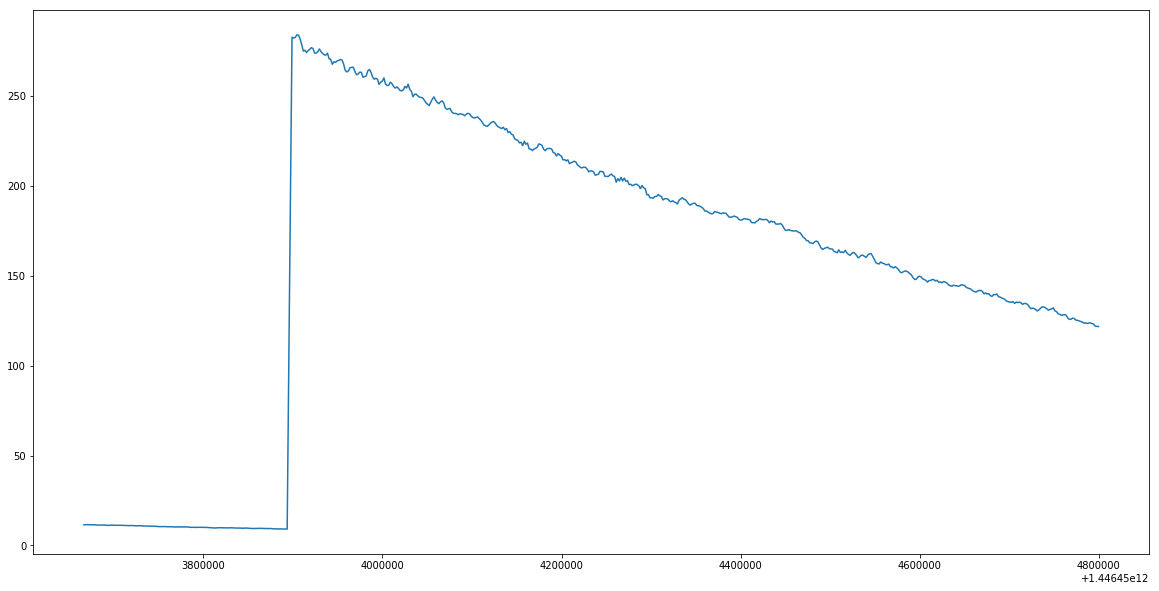

In [119]:
TIME_INTERVAL = '60T'

def calculate_rate(df):
    
    delta_time = df[DELTA_TIME].sum() / 1000 #convert to seconds
    delta_fuel = df[DELTA_FUEL].sum() 
    
    if not delta_time:
        return 0
    
    return delta_fuel / delta_time

def engine_state(df):
    
    if df[ENGINE_ON].isnull().all():
        return 0
   
    return df[ENGINE_ON].max()


def thefts(df):
    
    if df[IS_THEFT].isnull().all():
        return False
    if df[IS_THEFT].any():
        #print (df[[TIME,]].iloc[0])
        return True
    return False

groups = df.groupby([VEHICLE_ID])
for name, group in groups:
    
    group = group.set_index(DATETIME) 
    #rates = new_group.resample(TIME_INTERVAL).apply(calculate_rate)
    #engine_states = new_group.resample(TIME_INTERVAL).apply(engine_state)
    thefts = group.resample(TIME_INTERVAL).apply(thefts)
    
    print(thefts[thefts == True])
    
    
    start = datetime(2015, 11, 2, 7)
    end = datetime(2015, 11, 2, 9)
   
    #print(group[start:end][DELTA_FUEL])
    group = group[start:end]
    
    plt.figure(figsize=(20,10))
    plt.plot(group[[TIME]], group[[FUEL_LEVEL]])
    
    #date_slice = np.logical_and(new_group.index > start)
   
    #sliced_df = new_group[date_slice]

    #print(new_group.index.get_loc(d))
    #print (new_group.between_time(start, end))
    
    
    break



In [71]:
def get_deltatime(data, start, end):
    slice = vehicle.loc[start:end,:]
    t = timedelta(milliseconds=data[DELTA_TIME].sum())
    return str(t)

## #plot samples of fuel levels per time for one vehicle
vehicle = df.groupby([VEHICLE_ID]).get_group(10).copy()
#vehicle = vehicle.loc[907034:988023,:]

vehicle['index'] = vehicle.index
vehicle['DATETIME'] = pd.to_datetime(vehicle[TIME],unit='ms')
vehicle.set_index('DATETIME', drop=False, inplace=True)

vehicle = vehicle.loc[:,[DELTA_FUEL,DELTA_TIME,'index']]

vehicle = vehicle[vehicle['index'].isin(range(900240,900260))]
#print(vehicle)
ser = vehicle[DELTA_FUEL]
def f(data):
    #print("\n", data[DELTA_FUEL].sum())
    if data[DELTA_TIME].sum():
        delta = data[DELTA_TIME].sum()  / 1000
        return data[DELTA_FUEL].sum() / delta
    return 0

s = vehicle.resample('30T').apply(f)

print(s)
#print (get_deltatime(vehicle, 907034, 988023))

#print (vehicle['delta_fuel'].sum(), "total fuel")
#plt.figure(figsize=(20,10))
#plt.plot(vehicle[[TIME]], vehicle[[FUEL_LEVEL]])


'''
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col=VEHICLE_ID, hue=VEHICLE_ID, palette="tab20c",
                     col_wrap=10, height=1.5)
# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, TIME, FUEL_LEVEL)
'''

DATETIME
2015-10-16 18:30:00   -0.274
2015-10-16 19:00:00    0.000
2015-10-16 19:30:00    0.000
2015-10-16 20:00:00    0.000
2015-10-16 20:30:00    0.000
2015-10-16 21:00:00    0.000
2015-10-16 21:30:00    0.000
2015-10-16 22:00:00    0.000
2015-10-16 22:30:00    0.000
2015-10-16 23:00:00    0.000
2015-10-16 23:30:00    0.000
2015-10-17 00:00:00    0.000
2015-10-17 00:30:00    0.000
2015-10-17 01:00:00   -0.000
Freq: 30T, dtype: float64


'\n# Initialize a grid of plots with an Axes for each walk\ngrid = sns.FacetGrid(df, col=VEHICLE_ID, hue=VEHICLE_ID, palette="tab20c",\n                     col_wrap=10, height=1.5)\n# Draw a line plot to show the trajectory of each random walk\ngrid.map(plt.plot, TIME, FUEL_LEVEL)\n'

In [210]:

x = pd.DataFrame({'x': [66, 55, 56, 66, 67,66, 67 ], 
                  'y': [0, 1, 1, 1, 0,1,1], 
                  'z': [80, 90, 110, 120, 4, 120, 4]})


t = np.where(((x.y != x.y.shift(1)) & x.y).values)[0]
print(t)
'''print(x['y'].sum())
def f(d):
    print(d)
    print("name:", d.name,"\n")
'''
'''groups=x.groupby(['x']).apply(lambda x: print(x.name))
for name,g in groups:
    print(name,g)'''

'''x['flag'] = x['y'].diff().abs().cumsum().fillna(0) + 1
print(x['flag'])
for k,g in x.groupby('flag'):
    
    print (k,g)'''

x['block'] = (x.y.shift(1) != x.y).astype(bool).cumsum()
blocks = x.reset_index().groupby(['y','block'])['index'].apply(list)
blocks=blocks.to_frame()
print (blocks['y'])


'''for block in blocks:
    print(block)
true_cases = t[True]
print(true_cases,type(true_cases))
for i in true_cases:
    print(i,type(i))
'''

[1 5]


KeyError: 'y'